In [1]:
import os
import gc
import ast
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import torchaudio
import IPython.display as ipd
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models

import warnings
warnings.filterwarnings('ignore')

## Read and Analyze Training Metadata

In [2]:
df = pd.read_csv('../data/train_metadata.csv')
df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg


In [3]:
df.describe()

,latitude,longitude,rating
count,14852.000000,14852.000000,14852.000000
mean,35.778958,-30.217719,3.719129
std,22.288169,73.679144,1.181014
min,-71.883400,-176.632200,0.000000
25%,28.259200,-96.164300,3.000000
50%,40.870800,-6.061100,4.000000
75%,51.121950,10.897800,4.500000
max,78.978300,179.360700,5.000000


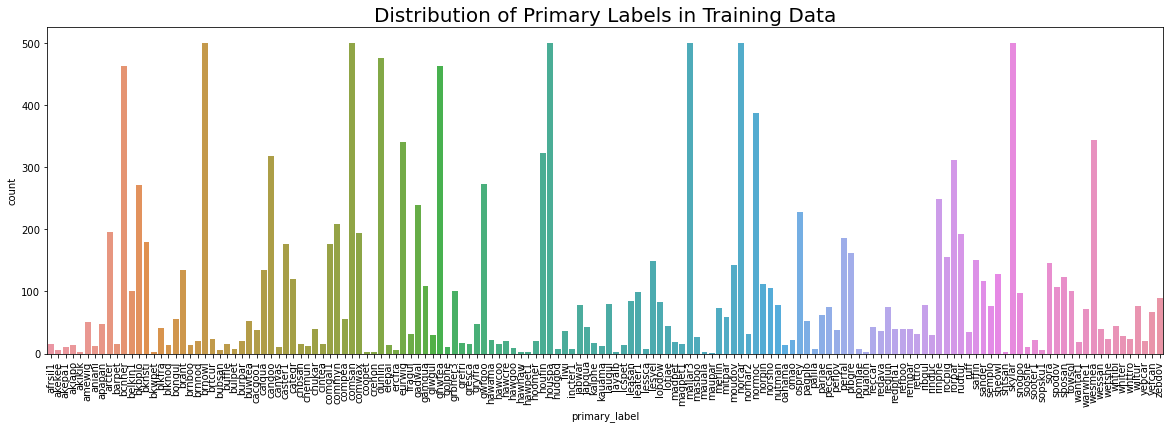

In [4]:
plt.figure(figsize=(20,6))

sns.countplot(df['primary_label'])
plt.xticks(rotation=90)
plt.title("Distribution of Primary Labels in Training Data", fontsize=20)

plt.show()

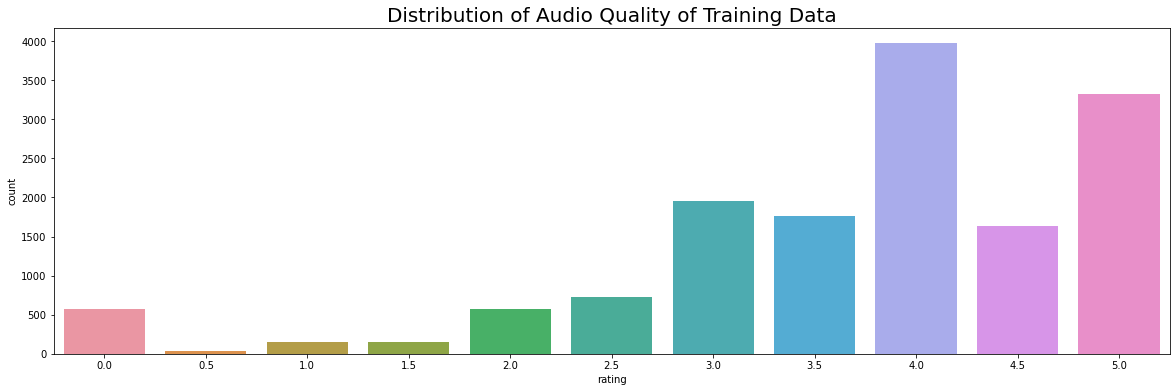

In [5]:
plt.figure(figsize=(20,6))
sns.countplot(df['rating'])
plt.title("Distribution of Audio Quality of Training Data", fontsize=20)
plt.show()

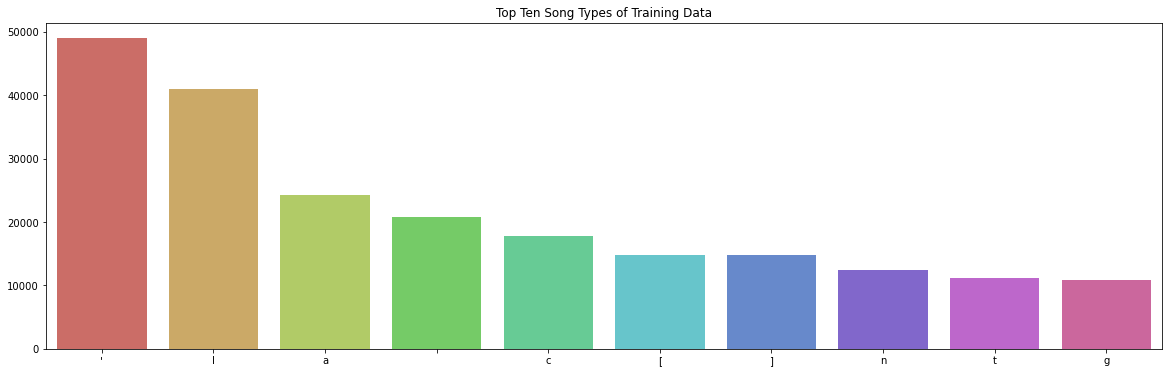

In [6]:
top_types = Counter([typ.lower() for lst in df['type'] for typ in lst])
top_types = dict(top_types.most_common(10))

plt.figure(figsize=(20,6))
sns.barplot(x=list(top_types.keys()), y=list(top_types.values()), palette='hls')
plt.title("Top Ten Song Types of Training Data")
plt.show()

## Audio File Analysis and Examples

In [7]:
fn_first = df['filename'].values[0]
ipd.Audio(f"../data/train_audio/{fn_first}")

In [8]:
fn_last = df['filename'].values[-1]
ipd.Audio(f"../data/train_audio/{fn_last}")

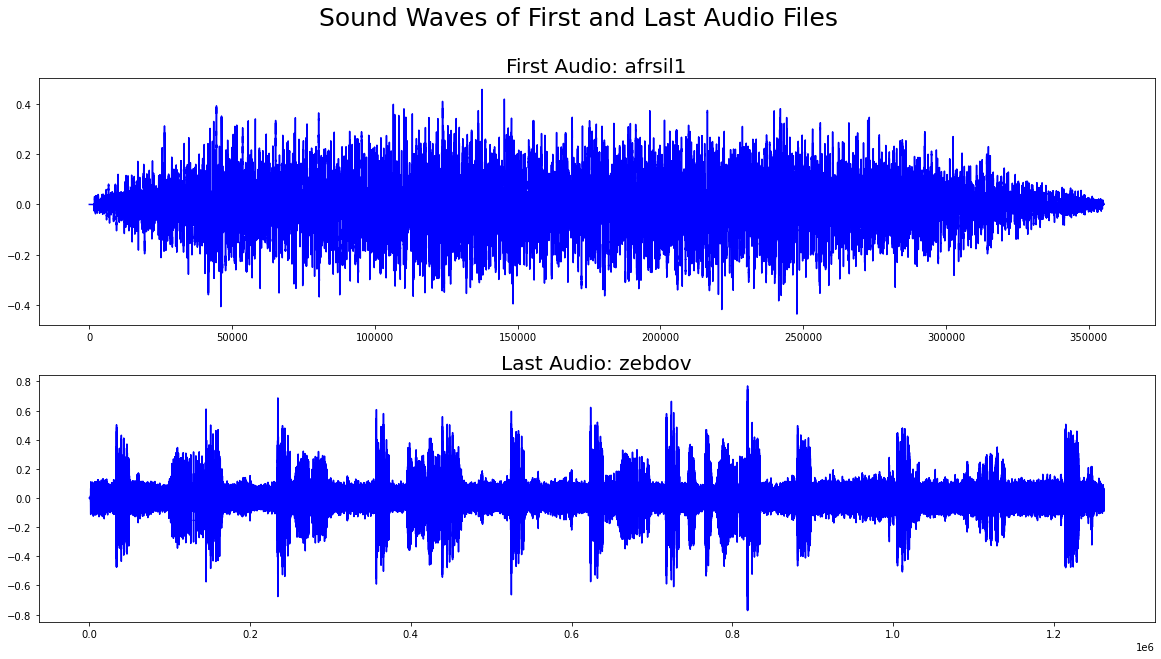

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(20,10))
fig.suptitle('Sound Waves of First and Last Audio Files', fontsize=25)

sig1, sr = torchaudio.load(f"../data/train_audio/{fn_first}")
sns.lineplot(x=np.arange(len(sig1[0,:].detach().numpy())), y=sig1[0,:].detach().numpy(), ax=ax[0], color='blue')
ax[0].set_title(f"First Audio: {df['primary_label'].values[0]}", fontsize=20)

sig2, sr = torchaudio.load(f"../data/train_audio/{fn_last}")
sns.lineplot(x=np.arange(len(sig2[0,:].detach().numpy())), y=sig2[0,:].detach().numpy(), ax=ax[1], color='blue')
ax[1].set_title(f"Last Audio: {df['primary_label'].values[-1]}", fontsize=20)

plt.show()

In [10]:
encoder = LabelEncoder()
df['primary_label_encoded'] = encoder.fit_transform(df['primary_label'])

In [11]:
skf = StratifiedKFold(n_splits=5)
for k, (_, val_ind) in enumerate(skf.split(X=df, y=df['primary_label_encoded'])):
    df.loc[val_ind, 'fold'] = k

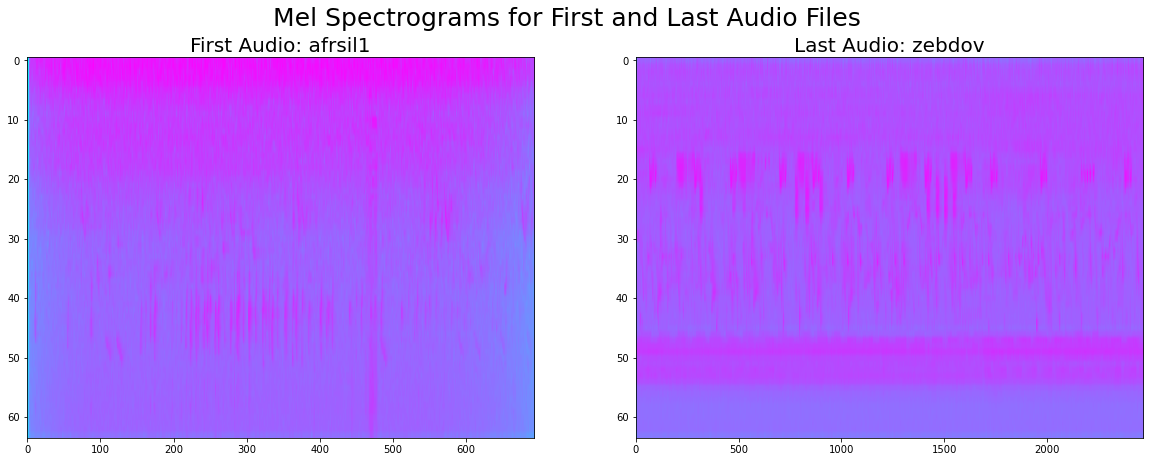

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20,7))
fig.suptitle('Mel Spectrograms for First and Last Audio Files', fontsize=25)

mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=32_000, n_fft=1024, hop_length=512, n_mels=64)

mel1 = mel_spectrogram(sig1)
ax[0].imshow(mel1.log2()[0,:,:].detach().numpy(), aspect='auto', cmap='cool')
ax[0].set_title(f"First Audio: {df['primary_label'].values[0]}", fontsize=20)

mel2 = mel_spectrogram(sig2)
ax[1].imshow(mel2.log2()[0,:,:].detach().numpy(), aspect='auto', cmap='cool')
ax[1].set_title(f"Last Audio: {df['primary_label'].values[-1]}", fontsize=20)

plt.show()

In [13]:
class BirdSongDataset(Dataset):
    def __init__(self, df, transformation, target_sample_rate, duration):
        self.audio_paths = df['filename'].values
        self.labels = df['primary_label_encoded'].values
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.num_samples = target_sample_rate * duration
        
    def __len__(self):
        return len(self.audio_paths)
    
    def __getitem__(self, index):
        audio_path = f"../data/train_audio/{self.audio_paths[index]}"
        sig, sr = torchaudio.load(audio_path)
        
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            sig = resampler(sig)
        
        if sig.shape[0] > 1:
            sig = torch.mean(sig, axis=0, keepdim=True)
            
        if sig.shape[1] > self.num_samples:
            sig = sig[:,:self.num_samples]
        elif sig.shape[1] < self.num_samples:
            num_missing = self.num_samples - sig.shape[1]
            last_dim_pad = (0, num_missing)
            sig = F.pad(sig, last_dim_pad)
        
        mel = self.transformation(sig)
        image = torch.cat([mel, mel, mel]) # 3 channels needed for pre-trained models
        max_val = torch.abs(image).max()
        image = image / max_val
        label = torch.tensor(self.labels[index])
        return image, label
        

In [14]:
def get_data(fold):
    train_df = df[df['fold'] != fold].reset_index(drop=True)
    valid_df = df[df['fold'] == fold].reset_index(drop=True)
    
    train_dataset = BirdSongDataset(train_df, mel_spectrogram, 32_000, 7)
    valid_dataset = BirdSongDataset(valid_df, mel_spectrogram, 32_000, 7)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)  
    
    return train_loader, valid_loader

In [15]:
class BirdSongModel(nn.Module):
    def __init__(self):
        super(BirdClefModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 8 * 54, 64)
        self.fc2 = nn.Linear(64, 152)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
class BirdSongResnet(nn.Module):
    def __init__(self):
        super(BirdSongResnet, self).__init__()
        self.base_model = models.__getattribute__('resnet50')(pretrained=True)
        for param in self.base_model.parameters():
            param.requires_grad = False
            
        in_features = self.base_model.fc.in_features
        
        self.base_model.fc = nn.Sequential(nn.Linear(in_features, 1024),
                                           nn.ReLU(),
                                           nn.Dropout(p=0.2),
                                           nn.Linear(1024, 512),
                                           nn.ReLU(),
                                           nn.Dropout(p=0.2),
                                           nn.Linear(512, 152))
        
    def forward(self, x):
        x = self.base_model(x)
        return x

In [17]:
def loss_fn(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

def train(model, data_loader, optimizer, scheduler, device, epoch):
    model.train()
    
    running_loss = 0
    loop = tqdm(data_loader, position=0)
    for i, (mels, labels) in enumerate(loop):
        mels = mels.to(device)
        labels = labels.to(device)
        
        outputs = model(mels)
        _, preds = torch.max(outputs, 1)
        
        loss = loss_fn(outputs, labels)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if scheduler is not None:
            scheduler.step()
            
        running_loss += loss.item()
        
        loop.set_description(f"Epoch [{epoch+1}/2]")
        loop.set_postfix(loss=loss.item())

    return running_loss/len(data_loader)

In [18]:
def valid(model, data_loader, device, epoch):
    model.eval()
    
    running_loss = 0
    pred = []
    label = []
    
    loop = tqdm(data_loader, position=0)
    for mels, labels in loop:
        mels = mels.to(device)
        labels = labels.to(device)
        
        outputs = model(mels)
        _, preds = torch.max(outputs, 1)
        
        loss = loss_fn(outputs, labels)
            
        running_loss += loss.item()
        
        pred.extend(preds.view(-1).cpu().detach().numpy())
        label.extend(labels.view(-1).cpu().detach().numpy())
        
        loop.set_description(f"Epoch [{epoch+1}/{2}]")
        loop.set_postfix(loss=loss.item())
        
    valid_f1 = f1_score(label, pred, average='macro')
    
    return running_loss/len(data_loader), valid_f1

In [19]:
def run(fold):
    train_loader, valid_loader = get_data(fold)
    
    #model = BirdClefModel().to(config.device) # check version 3 for this
    model = BirdSongResnet().to('cpu')
    
    optimizer = Adam(model.parameters(), lr=1e-4)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-5, T_max=10)
    
    best_valid_f1 = 0
    for epoch in range(2):
        train_loss = train(model, train_loader, optimizer, scheduler, 'cpu', epoch)
        valid_loss, valid_f1 = valid(model, valid_loader, 'cpu', epoch)
        if valid_f1 > best_valid_f1:
            print(f"Validation F1 Improved - {best_valid_f1} ---> {valid_f1}")
            torch.save(model.state_dict(), f'./model_{fold}.bin')
            print(f"Saved model checkpoint at ./model_{fold}.bin")
            best_valid_f1 = valid_f1
            
    return best_valid_f1

In [20]:
for fold in range(5):
    print("=" * 30)
    print("Training Fold - ", fold)
    print("=" * 30)
    best_valid_f1 = run(fold)
    print(f'Best F1 Score: {best_valid_f1:.5f}')
    
    gc.collect()
    torch.cuda.empty_cache()    
    break # To run for all the folds, just remove this break

Training Fold -  0


Epoch [1/2]:   3%|▌                    | 10/372 [00:32<19:44,  3.27s/it, loss=4.95]


KeyboardInterrupt: 